# Part 1: Generative Models: DCGAN

GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution.

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively.




In [3]:
%matplotlib inline

from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8684


-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [4]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Conv

In [5]:
class ConGenerator(nn.Module):
    def __init__(self, ngf, nc, ngpu=1):
        super(ConGenerator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class ConDiscriminator(nn.Module):
    def __init__(self, ndf, nc, ngpu=1):
        super(ConDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

**Weight Initialization**

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
def train(generator, discriminator, dataloader, image_size, nc):
    # Create the generator
    netG = generator(image_size, nc).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)
    
    # print(netG)

    # Create the Discriminator
    netD = discriminator(image_size, nc).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
        
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netD.apply(weights_init)

    # print(netD)

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Training Loop
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):            
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
            iters += 1
    
    # Loss versus training iteration
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

    # Real Images vs. Fake Images
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

### MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.9860	Loss_G: 5.3507	D(x): 0.7148	D(G(z)): 0.7247 / 0.0102
[0/5][50/469]	Loss_D: 0.0003	Loss_G: 28.1156	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.5284	Loss_G: 3.8153	D(x): 0.6702	D(G(z)): 0.0049 / 0.0387
[0/5][150/469]	Loss_D: 0.3596	Loss_G: 5.7662	D(x): 0.9427	D(G(z)): 0.2202 / 0.0044
[0/5][200/469]	Loss_D: 0.1309	Loss_G: 4.4246	D(x): 0.9339	D(G(z)): 0.0520 / 0.0198
[0/5][250/469]	Loss_D: 1.3845	Loss_G: 6.7657	D(x): 0.9345	D(G(z)): 0.6773 / 0.0026
[0/5][300/469]	Loss_D: 0.2255	Loss_G: 2.7807	D(x): 0.8663	D(G(z)): 0.0652 / 0.0826
[0/5][350/469]	Loss_D: 0.9854	Loss_G: 1.3960	D(x): 0.4799	D(G(z)): 0.0586 / 0.3237
[0/5][400/469]	Loss_D: 0.3789	Loss_G: 2.6206	D(x): 0.7995	D(G(z)): 0.1055 / 0.1145
[0/5][450/469]	Loss_D: 0.1214	Loss_G: 3.8049	D(x): 0.9169	D(G(z)): 0.0284 / 0.0312
[1/5][0/469]	Loss_D: 0.2352	Loss_G: 1.5916	D(x): 0.8281	D(G(z)): 0.0272 / 0

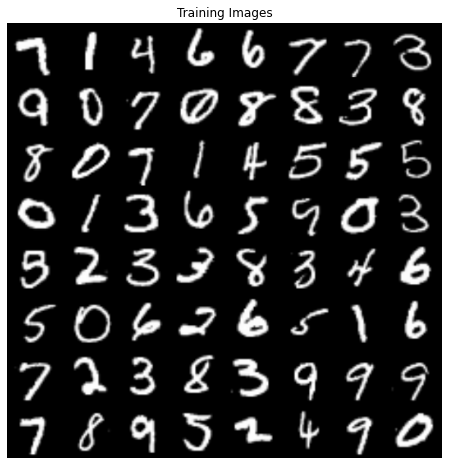

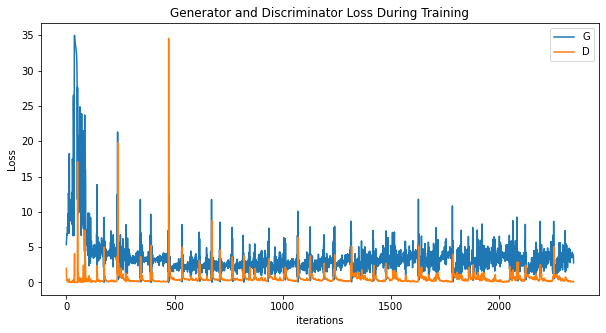

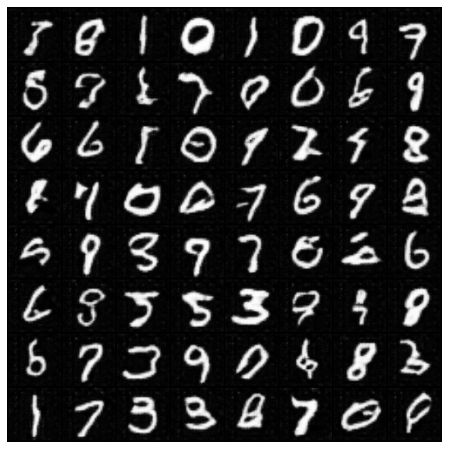

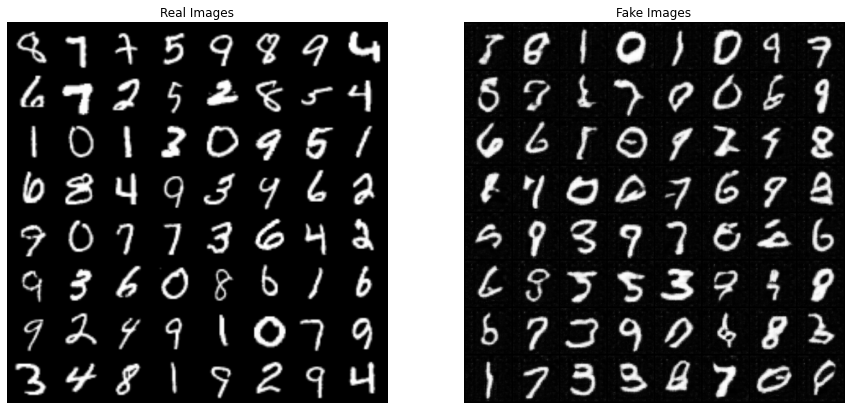

In [9]:
# celeba dataset
# !pip install --upgrade --no-cache-dir gdown
# !gdown 0B7EVK8r0v71pZjFTYXZWM3FlRnM && !unzip ./img_align_celeba.zip
# dataroot = "data/celeba"  # Root directory for dataset

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
mnist_dataset = dset.MNIST('data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]))

# Create the dataloader
mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(mnist_dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

train(ConGenerator, ConDiscriminator, mnist_dataloader, image_size, nc=1)

### CIFAR-10 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Starting Training Loop...
[0/5][0/391]	Loss_D: 1.7669	Loss_G: 6.1958	D(x): 0.5213	D(G(z)): 0.5690 / 0.0033
[0/5][50/391]	Loss_D: 0.2049	Loss_G: 11.6402	D(x): 0.8547	D(G(z)): 0.0011 / 0.0000
[0/5][100/391]	Loss_D: 0.3467	Loss_G: 4.3122	D(x): 0.8033	D(G(z)): 0.0437 / 0.0293
[0/5][150/391]	Loss_D: 0.2389	Loss_G: 4.7397	D(x): 0.8897	D(G(z)): 0.0979 / 0.0124
[0/5][200/391]	Loss_D: 0.1672	Loss_G: 8.2332	D(x): 0.9325	D(G(z)): 0.0762 / 0.0004
[0/5][250/391]	Loss_D: 0.4962	Loss_G: 14.9659	D(x): 0.9778	D(G(z)): 0.3160 / 0.0000
[0/5][300/391]	Loss_D: 1.2914	Loss_G: 7.5997	D(x): 0.9359	D(G(z)): 0.6167 / 0.0016
[0/5][350/391]	Loss_D: 0.4293	Loss_G: 4.2901	D(x): 0.9704	D(G(z)): 0.2799 / 0.0342
[1/5][0/391]	Loss_D: 0.3859	Loss_G: 4.7467	D(x): 0.9065	D(G(z)): 0.2277 / 0.0118
[1/5][50/391]	Loss_D: 0.4856	Loss_G: 5.1875	D(x): 0.9315	D(G(z)): 0.3035 / 0.0087
[1/5][100/391]	Loss_D: 0.9714	Loss_G: 3.7514	D(x): 0.5254	D(G(z)): 0.0136 / 0.0534
[1/5][150/391]	Los

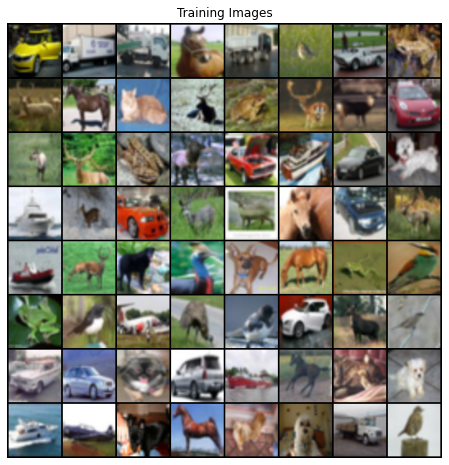

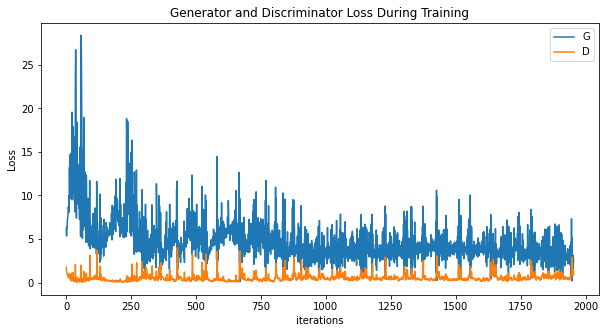

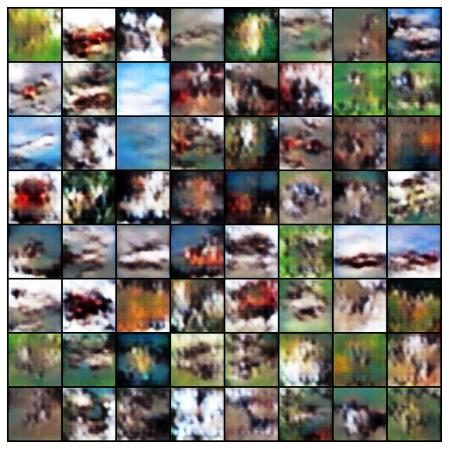

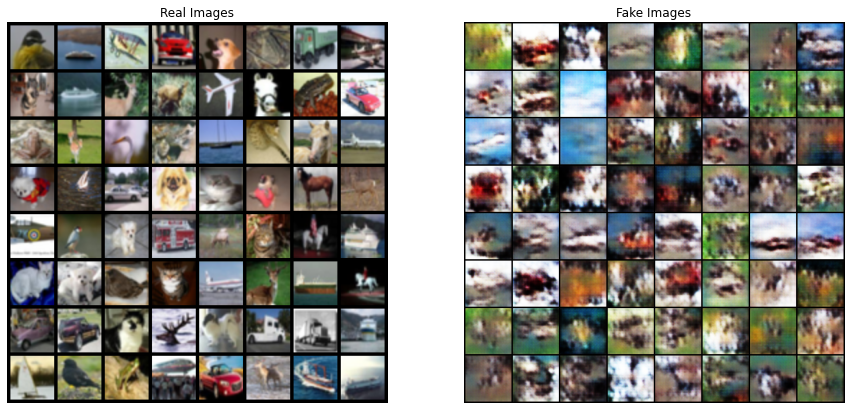

In [10]:
cifar_dataset = dset.CIFAR10('data', train=True, download=True, transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
cifar_dataloader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(cifar_dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

train(ConGenerator, ConDiscriminator, cifar_dataloader, image_size, nc=3)

## Linear model

In [11]:
class LinGenerator(nn.Module):
    def __init__(self, image_size, nc):
        self.nc = nc
        super().__init__()
        self.fc1 = nn.Linear(nz, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, image_size ** 2 * self.nc)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = nn.functional.tanh(self.fc4(x))
        x = x.view(x.size(0), self.nc, image_size, image_size)
        return x


class LinDiscriminator(nn.Module):
    def __init__(self, image_size, nc):
        super().__init__()
        self.fc1 = nn.Linear(image_size ** 2 * nc, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = nn.functional.dropout(x, 0.3)
        x = nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = nn.functional.dropout(x, 0.3)
        x = nn.functional.sigmoid(self.fc3(x))
        return x


### MNIST

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3536	Loss_G: 0.7205	D(x): 0.5041	D(G(z)): 0.4868 / 0.4865


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/5][50/469]	Loss_D: 1.2978	Loss_G: 0.7827	D(x): 0.6402	D(G(z)): 0.5662 / 0.4592
[0/5][100/469]	Loss_D: 1.0464	Loss_G: 1.0798	D(x): 0.7850	D(G(z)): 0.5452 / 0.3434
[0/5][150/469]	Loss_D: 1.4217	Loss_G: 0.6528	D(x): 0.6027	D(G(z)): 0.5877 / 0.5252
[0/5][200/469]	Loss_D: 1.0526	Loss_G: 1.2037	D(x): 0.7399	D(G(z)): 0.5173 / 0.3052
[0/5][250/469]	Loss_D: 0.5651	Loss_G: 1.3720	D(x): 0.8693	D(G(z)): 0.3389 / 0.2555
[0/5][300/469]	Loss_D: 0.5828	Loss_G: 1.7048	D(x): 0.8482	D(G(z)): 0.3174 / 0.1873
[0/5][350/469]	Loss_D: 0.4005	Loss_G: 1.9712	D(x): 0.9758	D(G(z)): 0.3049 / 0.1447
[0/5][400/469]	Loss_D: 0.4488	Loss_G: 1.7555	D(x): 0.8064	D(G(z)): 0.1802 / 0.1816
[0/5][450/469]	Loss_D: 0.4105	Loss_G: 2.5924	D(x): 0.8733	D(G(z)): 0.2136 / 0.0836
[1/5][0/469]	Loss_D: 0.4691	Loss_G: 2.5091	D(x): 0.9512	D(G(z)): 0.3211 / 0.0997
[1/5][50/469]	Loss_D: 0.4852	Loss_G: 2.5975	D(x): 0.7962	D(G(z)): 0.1576 / 0.1416
[1/5][100/469]	Loss_D: 0.5411	Loss_G: 2.0075	D(x): 0.7582	D(G(z)): 0.1894 / 0.1536
[1/5][15

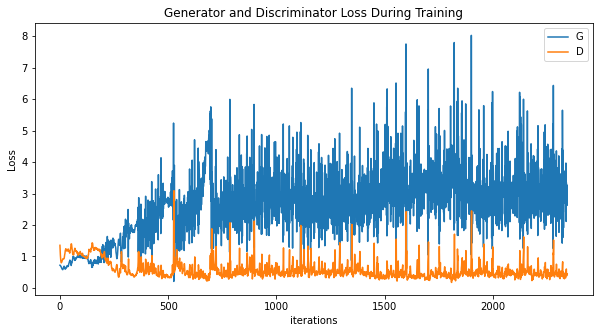

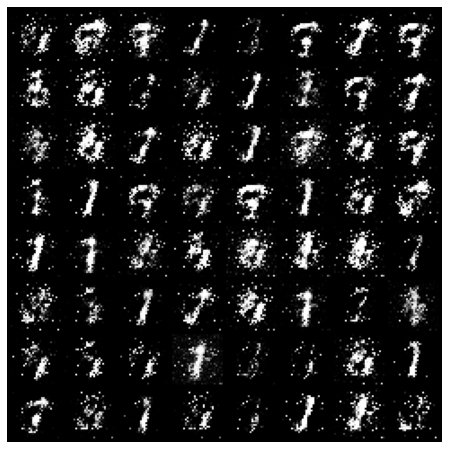

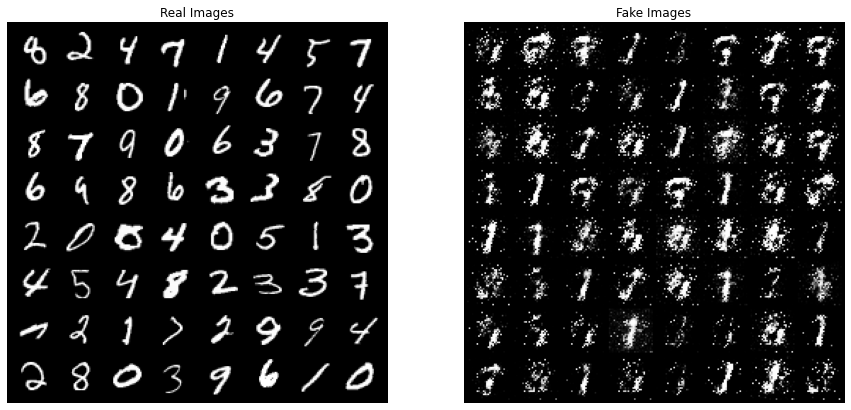

In [12]:
image_size = 28

mnist_dataset = dset.MNIST('data', train=True, download=True, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]))
mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

train(LinGenerator, LinDiscriminator, mnist_dataloader, image_size, nc=1)

### CIDAR-10

Files already downloaded and verified
Starting Training Loop...
[0/5][0/391]	Loss_D: 1.3898	Loss_G: 0.6748	D(x): 0.5134	D(G(z)): 0.5144 / 0.5093


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/5][50/391]	Loss_D: 0.8904	Loss_G: 0.8948	D(x): 0.9260	D(G(z)): 0.5513 / 0.4100
[0/5][100/391]	Loss_D: 0.5750	Loss_G: 1.0121	D(x): 0.9500	D(G(z)): 0.4040 / 0.3639
[0/5][150/391]	Loss_D: 0.4669	Loss_G: 1.2071	D(x): 0.9908	D(G(z)): 0.3662 / 0.2997
[0/5][200/391]	Loss_D: 0.2052	Loss_G: 1.9243	D(x): 0.9917	D(G(z)): 0.1779 / 0.1472
[0/5][250/391]	Loss_D: 0.2035	Loss_G: 2.8213	D(x): 0.9798	D(G(z)): 0.1589 / 0.0626
[0/5][300/391]	Loss_D: 4.1012	Loss_G: 2.0284	D(x): 0.7972	D(G(z)): 0.4509 / 0.2135
[0/5][350/391]	Loss_D: 0.2605	Loss_G: 3.3106	D(x): 0.9317	D(G(z)): 0.1438 / 0.0473
[1/5][0/391]	Loss_D: 0.3911	Loss_G: 4.2470	D(x): 0.9339	D(G(z)): 0.1727 / 0.0468
[1/5][50/391]	Loss_D: 0.3469	Loss_G: 3.4485	D(x): 0.9237	D(G(z)): 0.1746 / 0.0520
[1/5][100/391]	Loss_D: 0.2841	Loss_G: 4.0831	D(x): 0.9277	D(G(z)): 0.1380 / 0.0282
[1/5][150/391]	Loss_D: 0.3795	Loss_G: 3.5009	D(x): 0.8967	D(G(z)): 0.1493 / 0.0533
[1/5][200/391]	Loss_D: 0.4751	Loss_G: 3.5835	D(x): 0.8548	D(G(z)): 0.1352 / 0.0463
[1/5][25

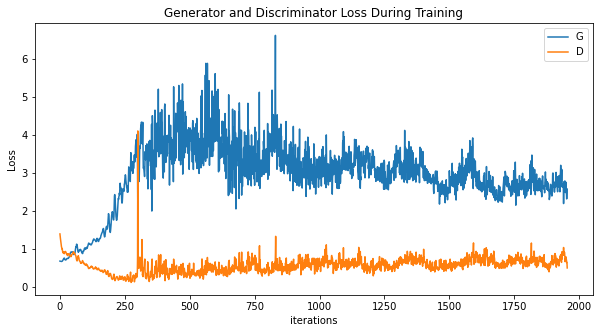

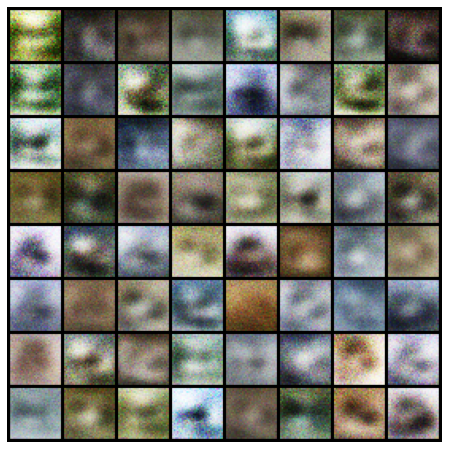

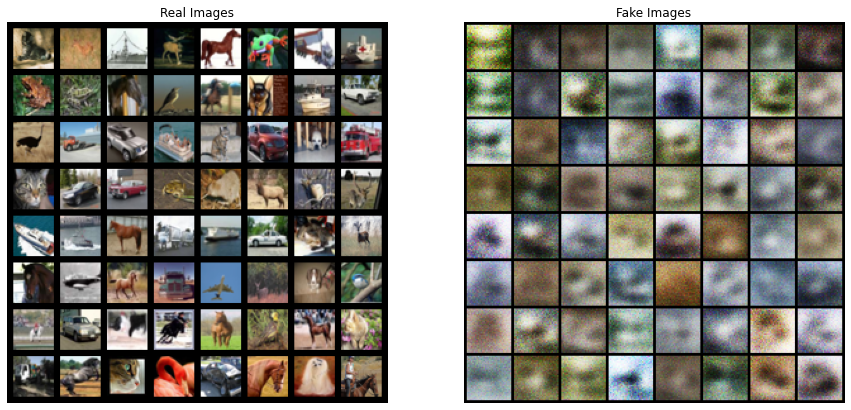

In [13]:
image_size = 32

cifar_dataset = dset.CIFAR10('data', train=True, download=True, transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
cifar_dataloader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

train(LinGenerator, LinDiscriminator, cifar_dataloader, image_size, nc=3)

# Part 2: PCA 

Files already downloaded and verified
Total variance explained by 307 principal components: 0.97


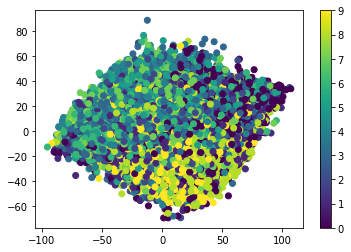

In [14]:
import torchvision
import numpy as np
from sklearn.decomposition import PCA

# Load CIFAR-10 dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# Flatten the images into a 2D array of shape (number of samples, number of features)
images, _ = next(iter(trainloader))
images = images.numpy().reshape(len(trainset), -1)

# Normalize the data
mean = np.mean(images, axis=0)
std = np.std(images, axis=0)
images = (images - mean) / std

# Perform PCA
pca = PCA(n_components=307)
pca.fit(images)

# Compute the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)
print(f"Total variance explained by 307 principal components: {total_variance:.2f}")

# Project the images onto the first two principal components
projection = pca.transform(images)[:, :2]

# Plot the projection
plt.scatter(projection[:, 0], projection[:, 1], c=trainset.targets)
plt.colorbar()
plt.show()


# K-Means Clustering 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


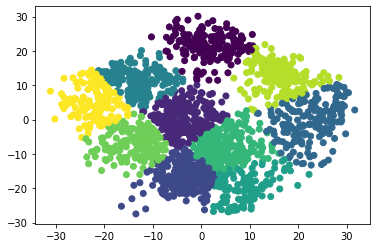

In [15]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the MNIST dataset
digits = load_digits()

# Reduce the dimensionality of the dataset using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(digits.data)

# Cluster the dataset using K-means
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)

# Plot the clustered dataset
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


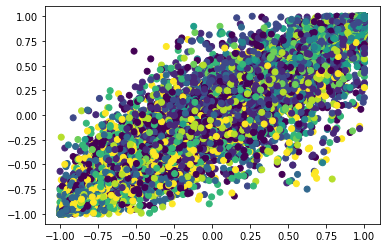

In [16]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
cifar10_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=1000,
                                              shuffle=True, num_workers=2)

# Flatten the CIFAR-10 dataset
cifar10_data = []
for images, _ in cifar10_loader:
    images = images.numpy()
    images = np.reshape(images, (images.shape[0], -1))
    cifar10_data.append(images)

cifar10_data = np.concatenate(cifar10_data, axis=0)

# Cluster the dataset using K-means
kmeans = KMeans(n_clusters=10)
kmeans.fit(cifar10_data)

# Plot the clustered dataset
plt.scatter(cifar10_data[:, 0], cifar10_data[:, 1], c=kmeans.labels_)
plt.show()
